# mBrain: Feature calculation

In [573]:
from mobiledna.core.appevents import Appevents
from mobiledna.core.sessions import Sessions
from mobiledna.core.notifications import Notifications

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report

## 1. Open the needed files

In [574]:
# file with the stress labels
df_eod_experiencekit = pd.read_parquet("../data/data_nervosity/df_eod_experiencekit.parquet")

# file with the mapping of the mobileDNA-id and the panelkit-id
df_mapping = pd.read_csv("../data/data_nervosity/MobileDNA_mapping_panelkitid.csv", sep=';')

# files needed for the feature calculation
ae = Appevents.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_appevents.csv", sep=';')
no = Notifications.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_notifications.parquet")
se = Sessions.load_data("../data/data_nervosity/wave_3_2/210803_nervocity_sessions.csv", sep=';')

ae.add_category(scrape=False).add_time_of_day()
no.add_category(scrape=False)
no.add_time_of_day(time_col='time')
no.__data__ = no.__data__.rename(columns={'TOD': 'startTOD'})  # sketchy but otherwise it won't work

# only keep the columns we need in the mapping file and experiencekit data
df_mapping = df_mapping[['panelkit_id', 'MobileDNA_id']]
df_eod_experiencekit = df_eod_experiencekit[['panelkit_id', 'daily_stress_level', 'timestamp']]
df_eod_experiencekit['day'] = df_eod_experiencekit['timestamp'].dt.date  # only keep date from timestamp
df_eod_experiencekit.pop('timestamp')

# add a column with the day for each appEvent
ae.__data__['day'] = ae.__data__['startTime'].dt.date
se.__data__['day'] = se.__data__['startDate'].dt.date

print('Modified appEvents data file: ')
print(ae.__data__.head())


2021-10-13 13:41:29 - Recognized file type as <csv>.


/Users/simonperneel/Documents/Imec-mict/mobiledna_py/mobiledna/core/help.py:178: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  res = f(*args, **kwargs)


2021-10-13 13:41:33 - 'load' took 3.507 seconds to complete.
2021-10-13 13:41:35 - Recognized file type as <parquet>.
2021-10-13 13:41:50 - 'load' took 15.604 seconds to complete.
2021-10-13 13:42:19 - Recognized file type as <csv>.
2021-10-13 13:42:20 - 'load' took 1.149 seconds to complete.


Adding tod <time>: 100%|██████████| 27772223/27772223 [00:15<00:00, 1850328.65it/s]


Modified appEvents data file: 
                                           id    model     session               startTime                 endTime  notification  notificationId                        application  battery   latitude  longitude   studyKey        surveyId data_version  startDate    endDate  duration category startTOD         day
1320339  001b6dc4-9c95-4c7c-a21a-56b5deca6689  ELE-L29  1622720128 2021-06-03 13:35:58.071 2021-06-03 13:36:02.945         False               0        com.huawei.android.launcher       63  51.057247   3.706872  nervocity  03062021lepato        1.6.1 2021-06-03 2021-06-03     4.874  unknown     noon  2021-06-03
1320340  001b6dc4-9c95-4c7c-a21a-56b5deca6689  ELE-L29  1622720128 2021-06-03 13:36:05.643 2021-06-03 13:36:22.971         False               0  com.google.android.apps.messaging       63  51.057247   3.706872  nervocity  03062021lepato        1.6.1 2021-06-03 2021-06-03    17.328     chat     noon  2021-06-03
1320293  001b6dc4-9c95-4c7c-a2

In [575]:
# load dummy data (for testing)
no_dummy = Notifications.load_data("./dummy_notifications.csv", sep=';')

2021-10-13 13:43:08 - Recognized file type as <csv>.
2021-10-13 13:43:08 - 'load' took 0.009 seconds to complete.


/Users/simonperneel/Documents/Imec-mict/mobiledna_py/mobiledna/core/help.py:178: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  res = f(*args, **kwargs)


## Output some info about the files
Shapes of the files:

In [576]:
# stress labels file
print("stress LABELS file: ")
print(f'> (rows, columns): {df_eod_experiencekit.shape[0], df_eod_experiencekit.shape[1]}')
# show some labels
#print(df_eod_experiencekit.daily_stress_level.head(3))
# stress levels distribution
#print(df_eod_experiencekit['daily_stress_level'].describe())
#print(df_eod_experiencekit['daily_stress_level'].value_counts(normalize=True))
print("----------------")
print("")

# mapping file
print("MAPPINGS file: ")
print(f'> (rows, columns): {df_mapping.shape[0], df_mapping.shape[1]}')
print("----------------")
print("")

# features file
print("MobileDNA DATA file: ")
print(f'> (rows, columns): {ae.__data__.shape[0], ae.__data__.shape[1]}')
print("----------------")
print("")

stress LABELS file: 
> (rows, columns): (4257, 3)
----------------

MAPPINGS file: 
> (rows, columns): (385, 2)
----------------

MobileDNA DATA file: 
> (rows, columns): (1489208, 20)
----------------



number of unique id's in each file:

In [577]:

print(f"number of unique id's in the mobileDNA data: {ae.__data__['id'].nunique()}")
print(f"number of unique id's in the mapping file: {df_mapping['MobileDNA_id'].nunique()}")
print(f"number of unique panelkit id's in the mapping file: {df_mapping['panelkit_id'].nunique()}")
print(f"number of unique panelkit id's in the experiencekit data: {df_eod_experiencekit['panelkit_id'].nunique()}")
print("-----------")
print("")

number of unique id's in the mobileDNA data: 326
number of unique id's in the mapping file: 274
number of unique panelkit id's in the mapping file: 377
number of unique panelkit id's in the experiencekit data: 447
-----------



## 2. Join the dataframes

In [578]:
# add the panelkit-id's to the mobileDNA data for shared MobileDNA id (inner join)
df_mapping = df_mapping.rename(columns={'MobileDNA_id': 'id'})
ae.__data__ = ae.__data__.merge(df_mapping, on='id')

print(f"number of unique id's after adding the panelkit-id to the MobileDNA data: {ae.__data__['id'].nunique()}")
print(f"number of entries in the MobileDNA data: {ae.__data__.shape[0]}")
# add the stress-level from experience-kit data to the mobileDNA data (inner join on panelkit-id and day)
ae.__data__ = pd.merge(ae.__data__, df_eod_experiencekit, on=['day', 'panelkit_id'])
print(f"number of entries in the MobileDNA data after adding the stresslabels: {ae.__data__.shape[0]}")

#print(ae.__data__['category'].unique())

number of unique id's after adding the panelkit-id to the MobileDNA data: 216
number of entries in the MobileDNA data: 932781
number of entries in the MobileDNA data after adding the stresslabels: 300105


The resulting file with the stress levels mapped to the mobileDNA-id's:

In [579]:
print(ae.__data__.head())

                                     id           model     session               startTime                 endTime  notification  notificationId                   application  battery   latitude  longitude   studyKey        surveyId data_version  startDate    endDate  duration category       startTOD         day                           panelkit_id daily_stress_level
0  00534866-5655-4e6c-ba15-dd5b5437041a  moto g(8) plus  1623038430 2021-06-07 06:15:00.433 2021-06-07 06:15:10.007          True              66  com.google.android.deskclock      100  51.069824   3.755381  nervocity  21061975frgear        1.6.1 2021-06-07 2021-06-07     9.574    clock  early_morning  2021-06-07  4af7b991-a5b3-11eb-9dd4-cb04303e036e                  5
1  00534866-5655-4e6c-ba15-dd5b5437041a  moto g(8) plus  1623039300 2021-06-07 06:30:00.377 2021-06-07 06:30:10.109          True              61  com.google.android.deskclock      100  51.069817   3.755354  nervocity  21061975frgear        1.6.1 2021-06-0

## 3. Feature calculation
All features from literature are listed [here](./Constructlijst_features.xlsx).
### Stress Features
#### General screen time

In [580]:
#df_features = ae.__data__.groupby(['id', 'day']).agg()
general_screen_time = (ae.get_daily_duration(series_unit='day') / 60)
print(general_screen_time.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    131.344917
                                      2021-06-08    122.027483
                                      2021-06-09    136.289317
                                      2021-06-11    190.306950
                                      2021-06-12     80.732533
Name: daily_durations, dtype: float64


#### Smartphone use frequency

In [581]:
smartphone_use_freq = ae.get_daily_events(series_unit=('day'))
print(smartphone_use_freq.head(2))

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    155.0
                                      2021-06-08    106.0
Name: daily_events, dtype: float64


#### Checking behaviour

In [582]:
checking_behaviour = se.get_daily_sessions(avg=False)
print(checking_behaviour.head())

avg_checking_behaviour = se.get_daily_sessions(avg=True)
print(avg_checking_behaviour.head())

id                                    startDate 
001b6dc4-9c95-4c7c-a21a-56b5deca6689  2021-06-03    13
                                      2021-06-08     1
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05    13
                                      2021-06-06    37
                                      2021-06-07    57
Name: avg_daily_sessions, dtype: int64
id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     7.000000
00534866-5655-4e6c-ba15-dd5b5437041a    51.241379
0079ff14-3579-4e27-b1e5-a838bc23b295    50.345238
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    26.750000
01617409-e832-4bd9-b139-30189de7e827    76.418605
Name: avg_daily_sessions, dtype: float64


#### Smartphone multitasking

In [583]:
# todo

#### Duration MIM applications

In [584]:
duration_MIM_applications = (ae.get_daily_duration(category='chat', series_unit='day') / 60)
print(duration_MIM_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    17.310767
                                      2021-06-08     9.991850
                                      2021-06-09    21.115133
                                      2021-06-11    38.756633
                                      2021-06-12     2.128450
Name: daily_durations_chat, dtype: float64


#### Frequency MIM applications

In [585]:
freq_MIM_applications = ae.get_daily_events(category='chat', series_unit='day')
print(freq_MIM_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    26.0
                                      2021-06-08    10.0
                                      2021-06-09    30.0
                                      2021-06-11    40.0
                                      2021-06-12     6.0
Name: daily_events_chat, dtype: float64


#### Notifications MIM applications

In [586]:
daily_MIM_notifications = no.get_daily_notifications(category='chat', avg=False)
print(daily_MIM_notifications.head())

avg_daily_MIM_notifications = no.get_daily_notifications(category='chat', avg=True)
print(avg_daily_MIM_notifications.head())

id                                    date      
001b6dc4-9c95-4c7c-a21a-56b5deca6689  2021-06-03    118
                                      2021-06-07     22
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05     10
                                      2021-06-06    110
                                      2021-06-07    213
Name: daily_notifications_chat, dtype: int64
id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     70.000000
00534866-5655-4e6c-ba15-dd5b5437041a    145.965517
0079ff14-3579-4e27-b1e5-a838bc23b295     75.369048
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     15.250000
01617409-e832-4bd9-b139-30189de7e827     91.505882
Name: avg_daily_notifications_chat, dtype: float64


#### (Average) daily use of MIM applications during work hours

In [587]:
# TODO change morning & noon to work hours (8-16 => 9-17)
daily_use_work_hours = (ae.get_daily_duration(time_of_day=['morning', 'noon'], category='chat', series_unit='day') / 60)
print(daily_use_work_hours.head())

avg_daily_use_work_hours = (ae.get_daily_duration(time_of_day=['morning', 'noon'], category='chat') / 60)
print(avg_daily_use_work_hours.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    7.450350
                                      2021-06-08    3.262033
                                      2021-06-09    3.089233
                                      2021-06-11    5.832850
                                      2021-06-12    0.410733
Name: daily_durations_chat_['morning', 'noon'], dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a     3.972924
0079ff14-3579-4e27-b1e5-a838bc23b295     6.442874
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     1.282050
03ce19e0-e1e9-4051-a1ac-afaac0557806     4.379676
0405c848-f9bf-4a27-9fc6-62b624287609    10.774242
Name: daily_durations_chat_['morning', 'noon'], dtype: float64


#### (Average) amount of social media notifications

In [588]:
# first put some more specific social categories in one general 'Social' category
unknown_categories = {"banking": ["com.coinbase.pro", "com.kraken.trade", "com.kraken.invest.app"],"medical": ["be.imec.apt.stressy","be.imec.apt.ichange.chillplusclient","be.ilabt.contextaware.empatica","be.ilabt.contextaware.mbrain","be.sciensano.coronalert","com.j_ware.polarsensorlogger","com.urbandroid.sleep","heartzones.com.heartzonestraining","com.empatica.e4realtime",],"calling": ["com.oneplus.dialer"],"calendar": ["com.komorebi.SimpleCalendar"],"productivity": ["partl.workinghours"],}

category_map = {"medical": "Health","chat": "Social","email": "Productivity","system": "none", "unknown": "none",
                "social": "Social","tools": "Productivity","browser": "Web","productivity": "Productivity",
                "photography": "none","business": "Productivity","music&audio": "Entertainment","clock": "none",
                "banking": "Finance","lifestyle": "none","health&fitness": "Health","news&magazines": "News",
                "gaming": "Entertainment","calling": "Calling","calendar": "Productivity","video": "Entertainment",
                "maps&navigation": "Navigation","food & drink": "none","finance": "Finance","communication": "Social",
                "ecommerce": "Shopping","retail": "Shopping","weather": "none","sports": "none","smartconnectivity": "none",
                "card": "Entertainment","travel & local": "none","education": "Productivity","entertainment": "Entertainment",
                "music & audio": "Entertainment","books & reference": "none","shopping": "Shopping","mobility": "Navigation",
                "news & magazines": "News","puzzle": "Entertainment",}

no.__data__['category'] = no.__data__['category'].apply(lambda x: category_map.get(x,x))

avg_daily_social_notifications = no.get_daily_notifications(category='Social')
print(avg_daily_social_notifications.head())

avg_daily_social_notifications = no.get_daily_notifications(category='Social', avg=True)
print(avg_daily_social_notifications.head())

id                                    date      
001b6dc4-9c95-4c7c-a21a-56b5deca6689  2021-06-03    123
                                      2021-06-07     23
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05     11
                                      2021-06-06    114
                                      2021-06-07    218
Name: daily_notifications_social, dtype: int64
id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     73.000000
00534866-5655-4e6c-ba15-dd5b5437041a    151.551724
0079ff14-3579-4e27-b1e5-a838bc23b295     77.666667
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     15.312500
01617409-e832-4bd9-b139-30189de7e827    100.209302
Name: avg_daily_notifications_social, dtype: float64


#### (Average) daily use of social media applications

In [589]:
i = ae.__data__['category'].nunique()
# first map some more specific social categories in one 'Social' category
ae.__data__['category'] = ae.__data__['category'].apply(lambda x: category_map.get(x,x))
j = ae.__data__['category'].nunique()
print(f'number of categories is reduced by {i-j}')

daily_social_applications = (ae.get_daily_duration(category='Social', series_unit='day') / 60)
print(daily_social_applications.head())

avg_daily_social_applications = (ae.get_daily_duration(category='Social') / 60)
print(avg_daily_social_applications.head())

number of categories is reduced by 29
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    20.110167
                                      2021-06-08    22.504683
                                      2021-06-09    28.751350
                                      2021-06-11    50.081050
                                      2021-06-12    28.248683
Name: daily_durations_social, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a     30.602396
0079ff14-3579-4e27-b1e5-a838bc23b295     13.065662
00a8c6be-edf7-45f5-90a6-cd0adb3d417d      4.737600
03ce19e0-e1e9-4051-a1ac-afaac0557806     76.685541
0405c848-f9bf-4a27-9fc6-62b624287609    126.107931
Name: daily_durations_social, dtype: float64


#### (Average) daily amount of social media app events

In [590]:
freq_social_applications = ae.get_daily_events(category='Social', series_unit='day')
print(freq_social_applications.head())

avg_freq_social_applications = ae.get_daily_events(category='Social')
print(avg_freq_social_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    32.0
                                      2021-06-08    14.0
                                      2021-06-09    37.0
                                      2021-06-11    49.0
                                      2021-06-12    24.0
Name: daily_events_social, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    33.000000
0079ff14-3579-4e27-b1e5-a838bc23b295    17.857143
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     9.428571
03ce19e0-e1e9-4051-a1ac-afaac0557806    67.818182
0405c848-f9bf-4a27-9fc6-62b624287609    73.916667
Name: daily_events_social, dtype: float64


#### Average daily use during evening time

In [591]:
daily_use_evening = (ae.get_daily_duration(time_of_day='eve', series_unit='day') / 60)
print(daily_use_evening.head())

avg_daily_use_evening = (ae.get_daily_duration(time_of_day='eve') / 60)
print(avg_daily_use_evening.head())


id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    37.616900
                                      2021-06-08    51.838833
                                      2021-06-09    55.775483
                                      2021-06-11    50.594233
                                      2021-06-12    22.114900
Name: daily_durations_eve, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    37.901985
0079ff14-3579-4e27-b1e5-a838bc23b295    26.582850
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     7.642969
03ce19e0-e1e9-4051-a1ac-afaac0557806    49.716194
0405c848-f9bf-4a27-9fc6-62b624287609    57.787203
Name: daily_durations_eve, dtype: float64


#### (Average) daily use during night time

In [592]:
daily_use_night = (ae.get_daily_duration(time_of_day='night', series_unit='day') / 60)
print(daily_use_night.head())

avg_daily_use_night = (ae.get_daily_duration(time_of_day='night') / 60)
print(avg_daily_use_night.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07     6.012000
                                      2021-06-08     6.165450
                                      2021-06-09     4.453050
                                      2021-06-11    18.644467
                                      2021-06-12    20.020767
Name: daily_durations_night, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    10.927101
0079ff14-3579-4e27-b1e5-a838bc23b295     9.603232
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     4.499922
03ce19e0-e1e9-4051-a1ac-afaac0557806     9.694495
0405c848-f9bf-4a27-9fc6-62b624287609    46.865879
Name: daily_durations_night, dtype: float64


#### (Average) daily amount of app events during evening/night time

In [593]:
freq_evening_use = (ae.get_daily_events(time_of_day='eve', series_unit='day'))
print(freq_evening_use.head())

avg_freq_evening_use = (ae.get_daily_events(time_of_day='eve'))
print(avg_freq_evening_use.head())

freq_night_use = (ae.get_daily_events(time_of_day='night', series_unit='day'))
print(freq_evening_use.head())

avg_freq_night_use = (ae.get_daily_events(time_of_day='night'))
print(avg_freq_evening_use.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    46.0
                                      2021-06-08    39.0
                                      2021-06-09    43.0
                                      2021-06-11    65.0
                                      2021-06-12    20.0
Name: daily_events_eve, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    36.214286
0079ff14-3579-4e27-b1e5-a838bc23b295    40.857143
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    13.333333
03ce19e0-e1e9-4051-a1ac-afaac0557806    42.000000
0405c848-f9bf-4a27-9fc6-62b624287609    63.250000
Name: daily_events_eve, dtype: float64
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    46.0
                                      2021-06-08    39.0
                                      2021-06-09    43.0
                                      2021-06-11    65.0
                                      2021-06-12    20.0
N

#### (Average) daily amount of notifications during evening/night time

In [594]:
daily_eve_notifications = no.get_daily_notifications(time_of_day='eve')
print(daily_eve_notifications.head())
avg_daily_eve_notifications = no.get_daily_notifications(time_of_day='eve', avg=True)
print(avg_daily_eve_notifications.head())
# amount of notifications is hoog

daily_night_notifications = (no.get_daily_notifications(time_of_day='night'))
print(daily_night_notifications.head())
avg_daily_night_notifications = (no.get_daily_notifications(time_of_day='night', avg=True))
print(avg_daily_night_notifications.head())
# amount of notifications is hoog

id                                    date      
001b6dc4-9c95-4c7c-a21a-56b5deca6689  2021-06-03     119
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05     122
                                      2021-06-06     579
                                      2021-06-07    1752
                                      2021-06-08    1324
Name: daily_notifications_eve, dtype: int64
id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     119.000000
00534866-5655-4e6c-ba15-dd5b5437041a    1048.310345
0079ff14-3579-4e27-b1e5-a838bc23b295     303.761905
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     334.400000
01617409-e832-4bd9-b139-30189de7e827     359.458824
Name: avg_daily_notifications_eve, dtype: float64
id                                    date      
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05    145
                                      2021-06-06    224
                                      2021-06-07    149
                                      2021-06-08    151
                                    

### Depression features
#### General screen time
#### Smartphone use frequency
#### Screen unlocks (=checking behaviour)
#### Average daily social smartphone use/ appevents/ notifications
#### Average smartphone appevents/ use during evening/night hours
 &#8594; All done above
#### (Average) time between sessions started on notification

In [595]:
def calc_time_between_notification_sessions(df: pd.DataFrame, avg=False):
    session_firsts = df.groupby(["id", "session"]).head(1)
    session_firsts_notif = session_firsts[session_firsts["notification"] == True]
    session_firsts_notif = session_firsts_notif.assign(start_shift= session_firsts_notif.groupby(["id", "startDate"])[["startTime"]].shift(-1))
    session_firsts_notif = session_firsts_notif.assign(duration_shift=(session_firsts_notif["start_shift"] - session_firsts_notif["endTime"]).dt.total_seconds())

    mean_shift_pd = (session_firsts_notif.groupby(["id", "startDate"])["duration_shift"].mean() / 60)
    mean_shift = mean_shift_pd.groupby("id").mean()

    if avg:
        return mean_shift.rename("mins_between_notif_sessions")
    else:
        return mean_shift_pd.rename("mins_between_notif_sessions")


In [596]:
time_between_notif_sessions = calc_time_between_notification_sessions(ae.__data__) # minutes
print(time_between_notif_sessions.head())

avg_time_between_notif_sessions = calc_time_between_notification_sessions(ae.__data__, avg=True) # minutes
print(avg_time_between_notif_sessions.head())

id                                    startDate 
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07     76.632692
                                      2021-06-08     64.602360
                                      2021-06-09     58.430013
                                      2021-06-11     56.834355
                                      2021-06-12    110.306744
Name: mins_between_notif_sessions, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a     81.851308
0079ff14-3579-4e27-b1e5-a838bc23b295    156.689824
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     96.114446
03ce19e0-e1e9-4051-a1ac-afaac0557806     60.503001
0405c848-f9bf-4a27-9fc6-62b624287609    120.954262
Name: mins_between_notif_sessions, dtype: float64


#### Variability smartphone use during week

In [597]:
def calc_weekly_use_variability(df: pd.DataFrame, duration: None):
    if duration:
        name = "duration"
        variability = df.groupby(["id", pd.Grouper(key="startDate", freq="W")])["duration"].sum().groupby("id").std()
    else:
        name = "appevents"
        variability = df.groupby(["id", pd.Grouper(key="startDate", freq="W")])["application"].count().groupby("id").std()

    return variability.rename(f"weekly_variability_{name}")

In [598]:
weekly_use_variability = calc_weekly_use_variability(ae.__data__, duration=True)
print(weekly_use_variability.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    27150.011119
0079ff14-3579-4e27-b1e5-a838bc23b295    24520.905596
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     1704.077845
03ce19e0-e1e9-4051-a1ac-afaac0557806     8278.414457
0405c848-f9bf-4a27-9fc6-62b624287609    11466.088596
Name: weekly_variability_duration, dtype: float64


#### (Average) daily use/events/notifications
##### non-social (process) related apps

In [599]:
social_cat = ["Social", "Calling"]
all_cat = ae.__data__.category.unique().tolist()
non_social_cat = list(set(all_cat) - set(social_cat))

daily_non_social_applications = (ae.get_daily_duration(category=non_social_cat, series_unit='day') / 60).rename('daily_durations_non_social')
print(daily_non_social_applications.head())
avg_daily_non_social_applications = (ae.get_daily_duration(category=non_social_cat) / 60).rename('avg_daily_durations_non_social')
print(avg_daily_non_social_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    94.995483
                                      2021-06-08    87.588267
                                      2021-06-09    94.868567
                                      2021-06-11    82.184417
                                      2021-06-12    49.986483
Name: daily_durations_non_social, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a     81.483679
0079ff14-3579-4e27-b1e5-a838bc23b295    108.518573
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     34.853764
03ce19e0-e1e9-4051-a1ac-afaac0557806     64.287779
0405c848-f9bf-4a27-9fc6-62b624287609     90.033018
Name: avg_daily_durations_non_social, dtype: float64


In [600]:
freq_non_social_applications = ae.get_daily_events(category=non_social_cat, series_unit='day').rename('daily_events_non_social')
print(freq_non_social_applications.head())
avg_freq_non_social_applications = ae.get_daily_events(category=non_social_cat).rename('daily_events_non_social')
print(avg_freq_non_social_applications.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    102.0
                                      2021-06-08     86.0
                                      2021-06-09     93.0
                                      2021-06-11    131.0
                                      2021-06-12     69.0
Name: daily_events_non_social, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a     93.571429
0079ff14-3579-4e27-b1e5-a838bc23b295    135.571429
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     43.000000
03ce19e0-e1e9-4051-a1ac-afaac0557806     66.000000
0405c848-f9bf-4a27-9fc6-62b624287609    151.833333
Name: daily_events_non_social, dtype: float64


In [601]:
daily_non_social_notifications = no.get_daily_notifications(category=non_social_cat)
print(daily_non_social_notifications.head())

avg_daily_non_social_notifications = no.get_daily_notifications(category=non_social_cat, avg=True)
print(avg_daily_non_social_notifications.head())

id                                    date      
001b6dc4-9c95-4c7c-a21a-56b5deca6689  2021-06-03     167
                                      2021-06-07     929
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-05     256
                                      2021-06-06    7339
                                      2021-06-07    7360
Name: daily_notifications_['contacts', 'video players & editors', 'web', 'arcade', 'beauty', 'entertainment', 'casual', 'role playing', 'news', 'personalization', 'house & home', 'auto & vehicles', 'productivity', 'finance', 'comics', 'strategy', 'dating', 'health&fitness ', 'health & fitness', 'video&audioconferencing', 'none', 'libraries & demo', 'educational', 'trivia', 'shopping', 'auto&vehicles', 'health', 'navigation', 'parenting', 'maps & navigation', 'board'], dtype: int64
id
001b6dc4-9c95-4c7c-a21a-56b5deca6689     548.000000
00534866-5655-4e6c-ba15-dd5b5437041a    3955.103448
0079ff14-3579-4e27-b1e5-a838bc23b295    1400.345238
00a8c6be-edf7-45f5-90

##### browser application

In [602]:
browser_use = (ae.get_daily_duration(category='Web') / 60)
print(browser_use.head())

freq_browser_use = ae.get_daily_events(category='Web', series_unit='day')
print(freq_browser_use.head())

id
00534866-5655-4e6c-ba15-dd5b5437041a    12.326779
0079ff14-3579-4e27-b1e5-a838bc23b295    20.719825
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     8.947675
03ce19e0-e1e9-4051-a1ac-afaac0557806     9.979317
0405c848-f9bf-4a27-9fc6-62b624287609    15.169649
Name: daily_durations_web, dtype: float64
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07     9.0
                                      2021-06-08    14.0
                                      2021-06-09    11.0
                                      2021-06-11    32.0
                                      2021-06-12     5.0
Name: daily_events_web, dtype: float64


##### news applications

In [603]:
news_use = (ae.get_daily_duration(category='News', series_unit='day') / 60)
print(news_use.head())

avg_news_use = (ae.get_daily_duration(category='News') / 60)
print(avg_news_use.head())

freq_news_use = ae.get_daily_events(category='News', series_unit='day')
print(freq_news_use.head())

avg_freq_news_use = ae.get_daily_events(category='News')
print(avg_freq_news_use.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07     6.787167
                                      2021-06-08    25.138267
                                      2021-06-09    20.978183
                                      2021-06-11    19.895983
                                      2021-06-12     7.749983
Name: daily_durations_news, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    23.801168
0079ff14-3579-4e27-b1e5-a838bc23b295    33.672029
0405c848-f9bf-4a27-9fc6-62b624287609     4.355336
073d1ad8-393c-41b1-be29-0626e1d02706     5.029817
09f3e8b7-16e7-4489-8216-9c7f7b91493f     6.038060
Name: daily_durations_news, dtype: float64
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07     5.0
                                      2021-06-08     6.0
                                      2021-06-09     8.0
                                      2021-06-11    11.0
                         

##### instagram

In [604]:
daily_instagram_use = (ae.get_daily_duration(application="com.instagram.android", series_unit='day') / 60).rename('daily_durations_instagram')
print(daily_instagram_use.head())

avg_daily_instagram_use = (ae.get_daily_duration(application="com.instagram.android") / 60).rename('avg_daily_durations_instagram')
print(avg_daily_instagram_use.head())

freq_instagram_use = ae.get_daily_events(application="com.instagram.android", series_unit='day').rename('daily_events_instagram')
print(freq_instagram_use.head())

avg_freq_instagram_use = ae.get_daily_events(application="com.instagram.android").rename('avg_daily_events_instagram')
print(avg_freq_instagram_use.head())

id                                    day       
00a8c6be-edf7-45f5-90a6-cd0adb3d417d  2021-06-07     9.516017
03ce19e0-e1e9-4051-a1ac-afaac0557806  2021-04-26    30.260383
                                      2021-04-27    40.614550
                                      2021-04-28     5.588667
                                      2021-04-29    28.764283
Name: daily_durations_instagram, dtype: float64
id
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     9.516017
03ce19e0-e1e9-4051-a1ac-afaac0557806    24.807552
0405c848-f9bf-4a27-9fc6-62b624287609     8.306463
09f3e8b7-16e7-4489-8216-9c7f7b91493f     9.466359
0b8a6b8d-575c-4216-ace4-3f677d4f0e0e     8.838978
Name: avg_daily_durations_instagram, dtype: float64
id                                    day       
00a8c6be-edf7-45f5-90a6-cd0adb3d417d  2021-06-07    11.0
03ce19e0-e1e9-4051-a1ac-afaac0557806  2021-04-26    10.0
                                      2021-04-27    23.0
                                      2021-04-28     1.0
           

### Headaches features
##### Daily screen time
&#8594; Already done above

##### (Average) Daily call duration/frequency

In [605]:
daily_call_duration = (ae.get_daily_duration(category='Calling', series_unit='day') /60)
print(daily_call_duration.head())

avg_daily_call_duration = (ae.get_daily_duration(category='Calling') /60)
print(avg_daily_call_duration.head())

freq_daily_call = ae.get_daily_events(category='Calling', series_unit='day')
print(freq_daily_call.head())

avg_freq_daily_call = ae.get_daily_events(category='Calling')
print(avg_freq_daily_call.head())

id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    16.239267
                                      2021-06-08    11.934533
                                      2021-06-09    12.669400
                                      2021-06-11    58.041483
                                      2021-06-12     2.497367
Name: daily_durations_calling, dtype: float64
id
00534866-5655-4e6c-ba15-dd5b5437041a    21.671875
0079ff14-3579-4e27-b1e5-a838bc23b295     0.565633
00a8c6be-edf7-45f5-90a6-cd0adb3d417d     2.175825
03ce19e0-e1e9-4051-a1ac-afaac0557806     0.508753
0405c848-f9bf-4a27-9fc6-62b624287609     2.814572
Name: daily_durations_calling, dtype: float64
id                                    day       
00534866-5655-4e6c-ba15-dd5b5437041a  2021-06-07    21.0
                                      2021-06-08     6.0
                                      2021-06-09     7.0
                                      2021-06-11    16.0
                   

### Activity features
##### Average daily number of (unique) used apps

In [606]:
# TODO unique apps

##### (Average) daily duration/ frequency of app use

In [607]:
# TODO

##### Increase/decrease in battery status

In [608]:
def calc_battery_status(df: pd.DataFrame):
    """
    Calculates four battery status variables per participant:
    - daily average battery level
    - daily std dev of battery level
    - daily average charge %
    - daily average discharge %

    :param df: the appevents DataFrame
    :return: results DataFrame with 4 variables per participant
    """
    df = df.copy()
    df = df.sort_values(['id', 'startTime']).assign(battery_shift= df.groupby(['id', 'startDate'])['battery'].shift(-1))
    df = df.assign(battery_change=df['battery_shift'] - df['battery'])

    battery_avg = (df.groupby(["id", "startDate"])["battery"].mean().groupby('id').mean()).rename('avg_daily_battery')
    battery_std = (df.groupby(["id", "startDate"])["battery"].mean().groupby('id').std()).rename("battery_std")

    battery_discharge = (df[df["battery_change"] < 0].groupby(['id', 'startDate'])['battery_change'].sum()
                         .abs().groupby('id').mean()).rename("battery_daily_discharge")
    battery_charge = (df[df["battery_change"] > 0].groupby(["id", "startDate"])["battery_change"].sum()
                      .abs().groupby("id").mean()).rename("battery_daily_charge")

    res = pd.concat([
        battery_charge,
        battery_discharge
    ], axis=1)

    return res

In [609]:
    battery_status = calc_battery_status(ae.__data__)
    print(battery_status.head())
    # TODO not completely right, averaging app events not best way
    # TODO per day

                                      battery_daily_charge  battery_daily_discharge
id                                                                                 
00534866-5655-4e6c-ba15-dd5b5437041a             32.250000                80.357143
0079ff14-3579-4e27-b1e5-a838bc23b295             77.615385                60.642857
00a8c6be-edf7-45f5-90a6-cd0adb3d417d             63.500000                34.857143
03ce19e0-e1e9-4051-a1ac-afaac0557806             66.625000                76.636364
0405c848-f9bf-4a27-9fc6-62b624287609             89.916667               119.583333


##### Average daily time between consecutive phone use sessions

In [610]:
def calc_time_between_consecutive_sessions(df: pd.DataFrame, avg=False):
    session_firsts = df.groupby(["id", "session"]).head(1)

    session_firsts = session_firsts.assign(start_shift= session_firsts.groupby(["id", "startDate"])[["startTime"]].shift(-1))
    session_firsts= session_firsts.assign(duration_shift=(session_firsts["start_shift"] - session_firsts["endTime"]).dt.total_seconds())

    mean_shift_pd = (session_firsts.groupby(["id", "startDate"])["duration_shift"].mean() / 60) # pd= per day
    mean_shift = mean_shift_pd.groupby("id").mean()  # avg by user

    if avg:
        return mean_shift.rename("mins_between_sessions")
    else:
        return mean_shift_pd.rename("mins_between_sessions")

In [611]:
daily_time_between_sessions = calc_time_between_consecutive_sessions(ae.__data__)
print(daily_time_between_sessions.index.dtype)
avg_daily_time_between_sessions = calc_time_between_consecutive_sessions(ae.__data__, avg=True)
print(avg_daily_time_between_sessions.head())

object
id
00534866-5655-4e6c-ba15-dd5b5437041a    23.782862
0079ff14-3579-4e27-b1e5-a838bc23b295    27.886837
00a8c6be-edf7-45f5-90a6-cd0adb3d417d    44.651391
03ce19e0-e1e9-4051-a1ac-afaac0557806    23.798553
0405c848-f9bf-4a27-9fc6-62b624287609    21.600834
Name: mins_between_sessions, dtype: float64


## 4. Merge all features in one dataframe

In [612]:
temp = (pd.merge(general_screen_time, smartphone_use_freq, on=['id', 'day']
).merge(duration_MIM_applications, on=['id', 'day']
).merge(freq_MIM_applications, on=['id', 'day']
).merge(daily_use_work_hours, on=['id', 'day']
).merge(daily_social_applications, on=['id', 'day']
).merge(freq_social_applications, on=['id', 'day']
).merge(daily_use_evening,  on=['id', 'day']
).merge(daily_use_night, on=['id', 'day']
).merge(freq_evening_use, on=['id', 'day']
).merge(freq_night_use, on=['id', 'day']
).merge(daily_non_social_applications, on=['id', 'day']
).merge(freq_non_social_applications, on=['id', 'day']
).merge(freq_browser_use, on=['id', 'day']
).merge(news_use, on=['id', 'day']
).merge(freq_news_use, on=['id', 'day']
).merge(daily_instagram_use, on=['id', 'day']
).merge(freq_instagram_use, on=['id', 'day']
).merge(daily_call_duration, on=['id', 'day']
).merge(freq_daily_call, on=['id', 'day']
))

# todo merge with other features
#level_to_change = -1
#temp.index = temp.index.set_levels(temp.index.levels[level_to_change].astype('datetime64[ns]'), level=level_to_change)
#print(temp.index.dtypes)
#print('')
#print(checking_behaviour.index.dtypes)

#print(checking_behaviour.index.dtypes)
#temp2 = pd.merge(temp, checking_behaviour, left_on=['id','day'], right_on=['id', 'startDate'])

#print(temp2.head())

#### Add stress labels

In [613]:
labels = ae.__data__[['id', 'day','daily_stress_level']].groupby(by=['id','day']).first().astype('float64')
res = pd.merge(temp, labels, on=['id', 'day'], sort=False)

The resulting dataframe with the features and labels per day, per user:

In [614]:
print(res.head())


                                                 daily_durations  daily_events  daily_durations_chat  daily_events_chat  daily_durations_chat_['morning', 'noon']  daily_durations_social  daily_events_social  daily_durations_eve  daily_durations_night  daily_events_eve  daily_events_night  daily_durations_non_social  daily_events_non_social  daily_events_web  daily_durations_news  daily_events_news  daily_durations_instagram  daily_events_instagram  daily_durations_calling  daily_events_calling  daily_stress_level
id                                   day                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Feature correlation/importance/selection/...

<AxesSubplot:title={'center':'Correlation of Numeric Features and Daily Stress Level'}>

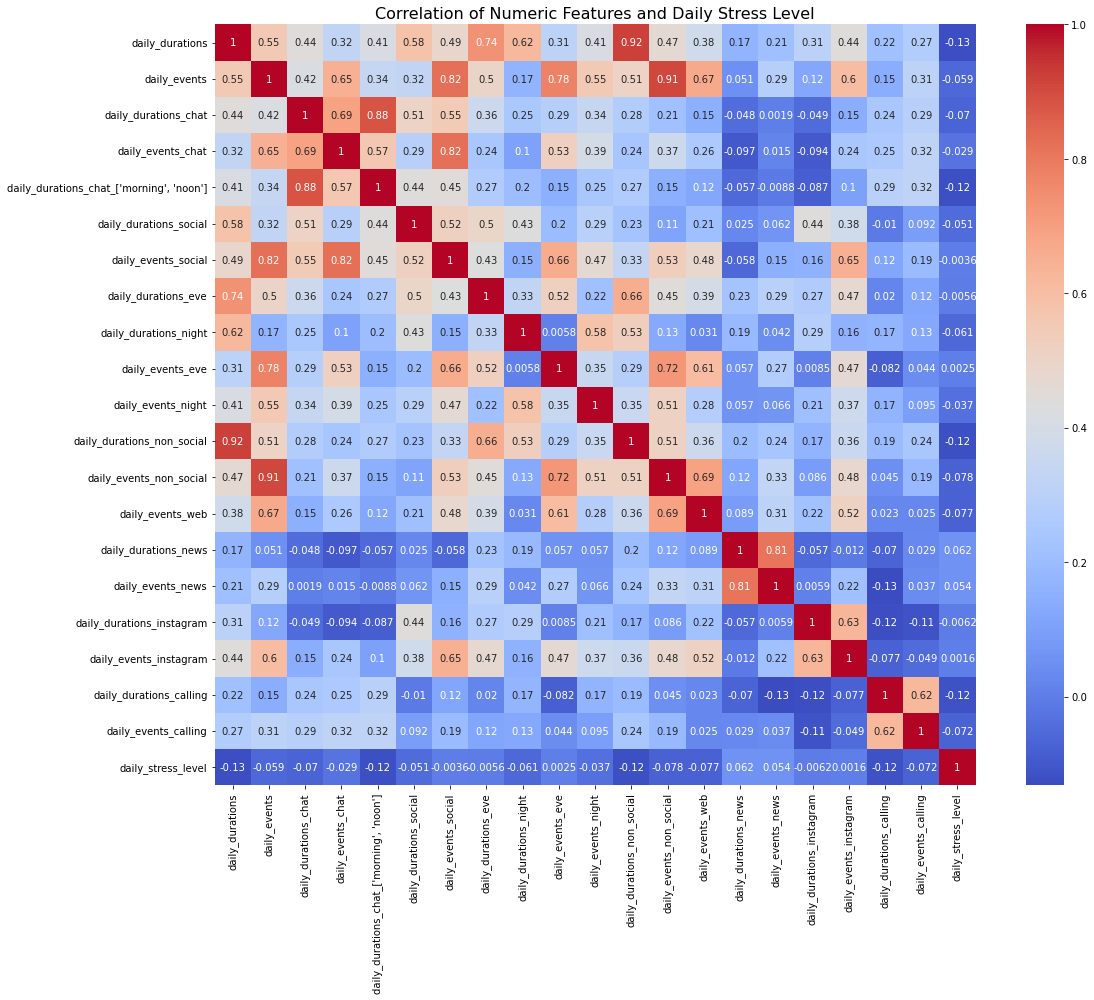

In [615]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation = res.corr()
f ,ax = plt.subplots(figsize = (18, 14))
plt.title('Correlation of Numeric Features and Daily Stress Level',y=1,size=16)
sns.heatmap(correlation, square= True, annot=True, cmap='coolwarm')

correlations with daily stress level:

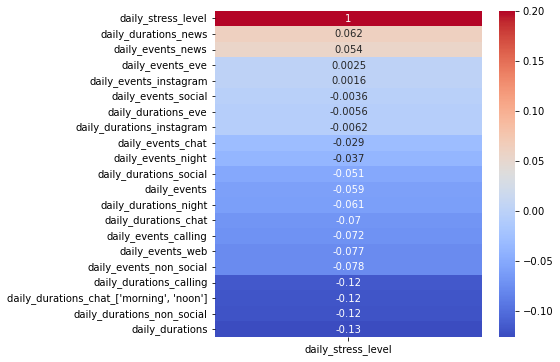

In [616]:
plt.figure(figsize=(6,6))
sns.heatmap(correlation[['daily_stress_level']].sort_values(by=['daily_stress_level'],ascending=False),
            cmap='coolwarm',
            vmax=0.2,
            annot=True);

Scatter plot of the most correlated variables:

<AxesSubplot:xlabel='daily_durations', ylabel='daily_stress_level'>

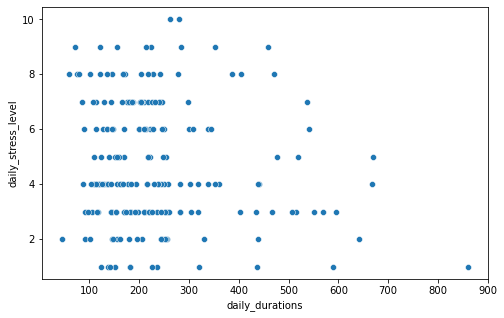

In [617]:
f ,ax = plt.subplots(figsize = (8, 5))
sns.scatterplot(x='daily_durations',y='daily_stress_level', data=res)



### F-test for each feature
Univariate linear regression tests returning F-statistic.
Explanation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html)


In [639]:
from sklearn.feature_selection import f_regression

feature_names = res.columns.tolist()
f_statistic,_ = f_regression(res, labels)

f_statistics = dict(sorted(zip(feature_names, f_statistic), key=lambda x:x[1], reverse=True))
print(f_statistics)

{'daily_durations': 3.2483060270356945, 'daily_durations_non_social': 2.9485174555450957, "daily_durations_chat_['morning', 'noon']": 2.907045017228144, 'daily_durations_calling': 2.7601066067070823, 'daily_events_non_social': 1.217288862655093, 'daily_events_web': 1.209505610990252, 'daily_events_calling': 1.0543339824160212, 'daily_durations_chat': 0.9908666124494085, 'daily_durations_news': 0.7649241983093445, 'daily_durations_night': 0.7451646440745698, 'daily_events': 0.7056323838842488, 'daily_events_news': 0.5783811931655526, 'daily_durations_social': 0.533458415931381, 'daily_events_night': 0.2775120636758709, 'daily_events_chat': 0.17327264043380552, 'daily_durations_instagram': 0.007614973780241511, 'daily_durations_eve': 0.006363041754244562, 'daily_events_social': 0.002602493857261461, 'daily_events_eve': 0.0012560009869834517, 'daily_events_instagram': 0.0005100871967058775}


### Try fitting a model

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True)


all_test_labels = []
all_predicted_labels = []

for i_fold, (tr, tst) in enumerate(k_fold.split(res, labels)):
    #print(f"fold number {i_fold}")
    res_train, res_test = res.iloc[tr], res.iloc[tst]
    labels_train, labels_test = labels[tr], labels[tst]
    clf = RandomForestClassifier()
    clf.fit(res_train, labels_train)
    predicted_label = clf.predict(res_test)

    all_test_labels.extend(labels_test)
    all_predicted_labels.extend(predicted_label)

print(classification_report(all_test_labels, all_predicted_labels))

In [620]:
print("FINISHED PROGRAM")


FINISHED PROGRAM
